In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

import copy
from random import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"On device: {device}")

On device: cpu


In [3]:
img_size = 400
preprocess = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()])

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
convert_to_pil_img = transforms.ToPILImage()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
vgg_19_cnn = models.vgg19(pretrained=True).features.to(device).eval()
# print(vgg_19_cnn)

def get_image(image_name):
    image = Image.open(image_name)
    npArray = np.array(image)
    image = cv2.cv2.resize(npArray, (img_size,img_size), interpolation = cv2.cv2.INTER_NEAREST )
    image = Image.fromarray(image)
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float)


def show_img(tensor, title='title required', save=False):
    img = tensor.cpu().clone()
    img = img.squeeze(0)
    img = convert_to_pil_img(img)
    if(save):
        file_name = str(randint(0,101))
        path = "./data/generated/generated_"+file_name+".jpg"
        img.save(path)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def get_gram_matrix(tensor):
    a, b, c, d = tensor.size()
    features = tensor.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d) #normalization+

def get_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [4]:
# t = torch.rand(1, 2,4, 4)
# print(t)
# t.view(-1, 1, 1)
# print(get_gram_matrix(t))

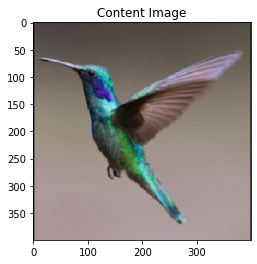

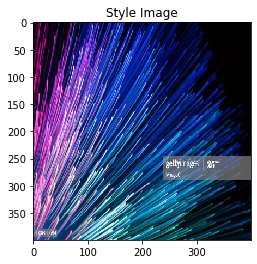

In [15]:
cnt_img = get_image('./data/images/bird.jpg')
style_img = get_image('./data/images/abstract_9.jpg')

assert style_img.size() == cnt_img.size()

show_img(cnt_img, title='Content Image')
show_img(style_img, title='Style Image')

In [16]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, tensor):
        self.loss = F.mse_loss(tensor, self.target)
        return tensor

    
class StyleLoss(nn.Module):
    def __init__(self, traget_style):
        super(StyleLoss, self).__init__()
        self.target = get_gram_matrix(traget_style).detach()
    
    def forward(self, tensor):
        g = get_gram_matrix(tensor)
        self.loss = F.mse_loss(g, self.target)
        return tensor

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, input):
        x = (input - self.mean) / self.std
        return x

In [17]:
# x = ContentLoss(cnt_img)
# print(x)
# print(cnt_img.size())
# d_i = torch.rand(3, 400, 400)
# show_img(d_i)
# # print(f"random : {d_i}")
# # print(f"actual: {cnt_img}")
# show_img(cnt_img)
# # print(f"e_d: {x(d_i)}")
# show_img(x(d_i))
# # print(x(d_i).size())
# print(torch.all(d_i.eq(x(d_i))))

In [18]:
def get_model_and_losses(cnn, mean, std, style_img, cnt_img, cnt_layers=content_layers_default,
                         style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(mean,std).to(device)
    cnt_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i = i + 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        if name in cnt_layers:
            target = model(cnt_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            cnt_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses ?
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
     
    model = model[:(i + 1)]
#     print(f"model: {model}")   
    return model, style_losses, cnt_losses

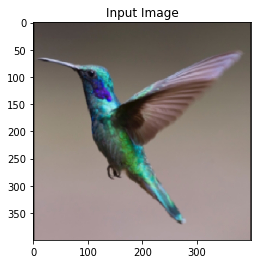

In [19]:
input_img = cnt_img.clone() #Using content image as input image
plt.figure()
show_img(input_img, title='Input Image')

In [20]:
def transfer_style(cnn, mean, std,cnt_img, style_img, input_img, num_steps=300,style_weight=1000000, cnt_weight=1):
    print('Started style transfer...')
    model, style_losses, content_losses = get_model_and_losses(cnn, mean, std, style_img, cnt_img)
    optimizer = get_optimizer(input_img)
    print('Started optimizing...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= cnt_weight

            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    print('Optimization done.')
    print('Style transfered.')
    input_img.data.clamp_(0, 1)

    return input_img

In [21]:
# x = 0
# print(x)
# x += 1
# print(x)
# show_img(cnt_img)
# print(cnt_img)
# x = cnt_img.data.clamp_(0,1)
# show_img(cnt_img.data.clamp_(0,1))
# print(x)

Started style transfer...


C:\Users\Piktorlabs\Anaconda3\envs\cnn_py\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Piktorlabs\Anaconda3\envs\cnn_py\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Started optimizing...
run [50]:
Style Loss : 1241.895752 Content Loss: 47.347084

run [100]:
Style Loss : 297.208893 Content Loss: 49.008003

run [150]:
Style Loss : 142.902954 Content Loss: 50.070724

Optimization done.
Style transfered.


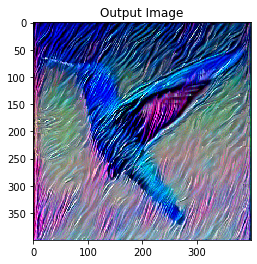

In [22]:
ITERATION = 150
STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1

output = transfer_style(vgg_19_cnn, cnn_normalization_mean, cnn_normalization_std,
                            cnt_img, style_img, input_img,ITERATION, STYLE_WEIGHT, CONTENT_WEIGHT)

plt.figure()
show_img(output, title='Output Image', save=True)

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()